In [29]:
%qtconsole

In [47]:
%matplotlib inline
from __future__ import print_function

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd
import random

from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import normalize
from sklearn.grid_search import GridSearchCV
from sklearn import ensemble
from sklearn import linear_model
from sklearn import svm

from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split

In [107]:
microclimate_train = pd.read_csv('dataset/Training set Microclimate (2 hour intervals).csv',
                                 index_col=0, parse_dates=[0])

microclimate_test = pd.read_csv('dataset/Test set Microclimate (2 hour intervals).csv',
                                index_col=0, parse_dates=[0])

labels = pd.read_csv('dataset/Target Variable Water Yield.csv',
                     index_col=0, parse_dates=[0])

submission_format = pd.read_csv('dataset/Submission format.csv',
                                index_col=0, parse_dates=[0])

microclimate_5min = pd.read_csv('dataset/Training set Microclimate (5 minute intervals).csv',
                                 index_col=0, parse_dates=[0])

In [372]:
weights = []

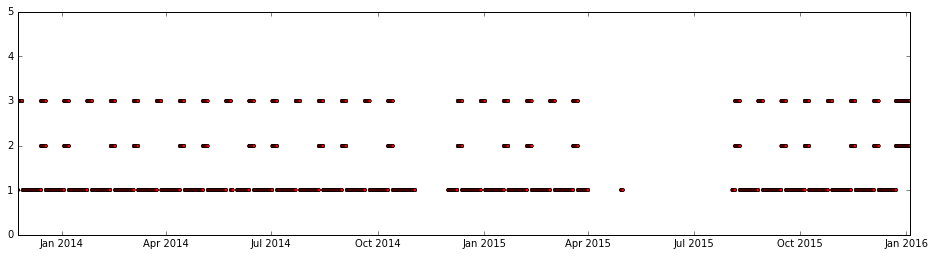

In [4]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_test_time = microclimate_test.copy()
y_test_time = submission_format.copy()

fig, ax = plt.subplots(figsize=(16, 4))

ax.plot_date(X_time.index, [1 for i in xrange(y_time.shape[0])], c='r', ms=3)
ax.plot_date(X_test_time.index, [2 for i in xrange(X_test_time.shape[0])], c='r', ms=3)
ax.plot_date(y_test_time.index, [3 for i in xrange(y_test_time.shape[0])], c='r', ms=3)
ax.set_ylim([0, 5])

plt.show()

In [343]:
X_time = microclimate_train.copy()
y_time = labels.copy()
X_joint = microclimate_train.copy()

for i in [2]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)

In [313]:
X_train_pre_yield, X_test_pre_yield, y_train_pre_yield, y_test_pre_yield = train_test_split(X_joint,
                                                    y_time,
                                                    test_size=0.3, random_state=100)

In [314]:
steps_random_forest = [('imputer', Imputer()),
         ('pca', PCA()),
         ('rf', ensemble.RandomForestRegressor())]
pipe_random_forest = Pipeline(steps_random_forest)

# create the grid search
params = {
    'pca__n_components': range(2, X_train_pre_yield.shape[1]),
    'imputer__strategy': ['mean', 'median', 'most_frequent'],
    'rf__n_estimators': [5, 10, 20],
}

In [315]:
estimator_random_forest = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
estimator_random_forest.fit(X_train_pre_yield, y_train_pre_yield.values.ravel())

y_hat_pre_yield_random_forest = estimator_random_forest.predict(X_test_pre_yield)
rmse_pre_yield_random_forest = np.sqrt(mean_squared_error(y_test_pre_yield, y_hat_pre_yield_random_forest))
rmse_pre_yield_random_forest

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 216 out of 216 | elapsed:   22.3s finished


1.74614372233364

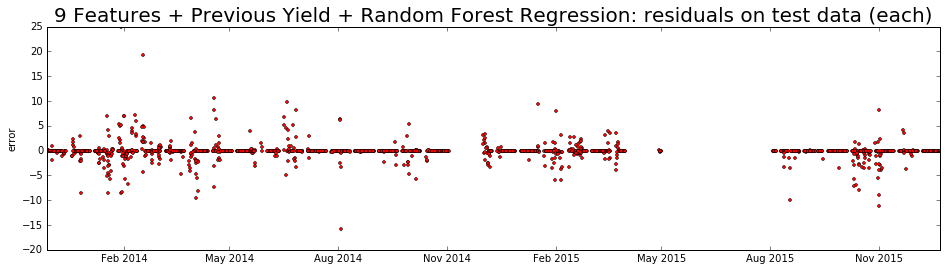

In [64]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_test_pre_yield.values.ravel() - y_hat_pre_yield_random_forest

ax.plot_date(y_test_pre_yield.index, err, c='r', ms=3)
ax.set_title('9 Features + Previous Yield + Random Forest Regression: residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

<div class="alert alert-danger">
Classifier.
</div>

In [373]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()

for timestamp in y_time.index:
    if y_time.loc[timestamp]['yield'] > 0:
        y_time.loc[timestamp]['yield'] = 1

X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

normalize(X_time, copy=False)

array([[ 0.        ,  0.00091682,  0.01788412, ...,  0.00739163,
         0.27372533,  0.00662224],
       [ 0.        ,  0.00092281,  0.01775545, ...,  0.00761486,
         0.27220775,  0.0069001 ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.00745248,
         0.27227188,  0.00675496],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00748404,
         0.15971649,  0.00572088],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00978416,
         0.1629566 ,  0.00888447],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.01075866,
         0.14647318,  0.00986602]])

In [374]:
X_train, X_test, y_train, y_test = train_test_split(X_time,
                                                    y_time,
                                                    test_size=0.3, random_state=100)

In [375]:
estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_train)
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] != y_hat[i]:
        wrong_predict_count += 1
        if y_test.values[i] == 0:
            zero_to_one += 1
        else:
            one_to_zero += 1
    else:
        if y_test.values[i] == 0:
            zero_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test size = 1734
right_predict_count = 1638
in right_predict_count: zero_to_zero = 1318
in right_predict_count: one_to_one = 320
wrong_predict_count = 96
in wrong_predict_count: zero_to_one = 43
0.0315944158707
in wrong_predict_count: one_to_zero = 53
0.142091152815
0.14745308311


0.94463667820069208

<div class="alert alert-danger">
Regression.
</div>

In [376]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()
        
X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

normalize(X_time, copy=False)

array([[ 0.        ,  0.00091682,  0.01788412, ...,  0.00739163,
         0.27372533,  0.00662224],
       [ 0.        ,  0.00092281,  0.01775545, ...,  0.00761486,
         0.27220775,  0.0069001 ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.00745248,
         0.27227188,  0.00675496],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00748404,
         0.15971649,  0.00572088],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00978416,
         0.1629566 ,  0.00888447],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.01075866,
         0.14647318,  0.00986602]])

In [377]:
X_train, X_test, y_train, y_test = train_test_split(X_time,
                                                    y_time,
                                                    test_size=0.3, random_state=100)

In [389]:
estimator = ensemble.RandomForestRegressor()
estimator.fit(X_train, y_train)
y_hat_regression = estimator.predict(X_test)


# steps_random_forest = [('imputer', Imputer()),
#          ('pca', PCA()),
#          ('rf', ensemble.RandomForestRegressor())]
# pipe_random_forest = Pipeline(steps_random_forest)

# # create the grid search
# params = {
#     'pca__n_components': range(2, X_train.shape[1]),
#     'imputer__strategy': ['mean', 'median', 'most_frequent'],
#     'rf__n_estimators': [5, 10, 20]
# }
# estimator = GridSearchCV(pipe_random_forest, param_grid=params, n_jobs=-1, verbose=1)
# estimator.fit(X_train, y_train.values.ravel())

# y_hat_regression = estimator.predict(X_test)
print(X_time.dtypes)
print(estimator.feature_importances_)

weight = estimator.feature_importances_
weight = np.insert(weight, 9, 0)
weight = np.insert(weight, 10, 0)
weights.append(weight)

percip_mm         float64
humidity          float64
temp              float64
leafwet450_min    float64
leafwet460_min    float64
leafwet_lwscnt    float64
gusts_ms          float64
wind_dir          float64
wind_ms           float64
dtype: object
[ 0.05344267  0.12134781  0.07275406  0.50976204  0.04029656  0.04283151
  0.04292879  0.03161359  0.08502298]


/Users/Shauro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [82]:
# for i in xrange(y_hat.shape[0]):
#     if y_hat[i] == 1:
#         y_hat[i] = y_hat_regression[i]
        
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

2.0701903248284124

In [323]:
estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_train.values.ravel())
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] != y_hat[i]:
        wrong_predict_count += 1
        if y_test.values[i] == 0:
            zero_to_one += 1
        else:
            one_to_zero += 1
    else:
        if y_test.values[i] == 0:
            zero_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

ValueError: Unknown label type: array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 0.],
       [ 0.],
       [ 0.]])

In [324]:
y_classifier = np.copy(y_hat)
y_regression = np.copy(y_hat_regression)

predict_total = y_test.copy()

for i in xrange(y_regression.shape[0]):
    if abs(y_regression[i]) < 0.01 :
        y_regression[i] = 0
# print(y_regression)

predict_total['y_classider'] = y_classifier
predict_total['y_regression'] = y_regression

# for i in xrange(y_regression.shape[0]):
#     predict_total.append((y_classifier[i], y_regression[i], y_test.values[i]))
# print(predict_total)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0

for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

rmse = np.sqrt(mean_squared_error(y_test, y_regression))
print('loss =', rmse)
        
predict_total.head(n=1734)

predict_total.to_csv("./three_combine.csv")

test size = 1734
right_predict_count = 1576
in right_predict_count: zero_to_zero = 1232
in right_predict_count: one_to_one = 344
wrong_predict_count = 158
in wrong_predict_count: zero_to_one = 129
0.094783247612
in wrong_predict_count: one_to_zero = 29
0.0777479892761
loss = 2.21158697958


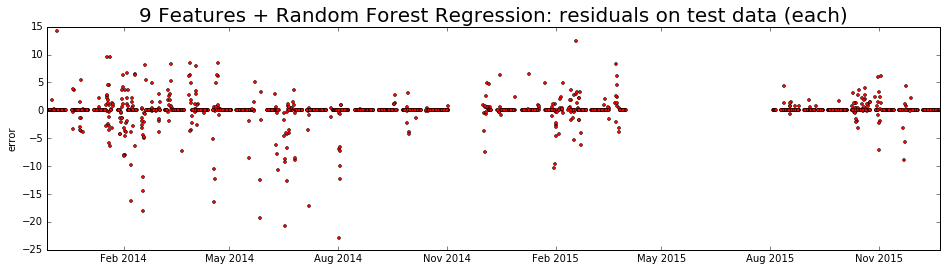

In [87]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_regression - y_test.values.ravel()

ax.plot_date(y_test.index, err, c='r', ms=3)
ax.set_title('9 Features + Random Forest Regression: residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

# cc = 0
# for i in xrange(err.shape[0]):
#     if y_regression[i] - y_test.values[0][i] < 0:
#         cc += 1

<div class="alert alert-danger">
Add previous yield.
</div>

In [391]:
X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()
        
X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

In [392]:
X_joint = X_time.copy()
y_new = y_time.copy()
for i in [2]:
    offset = i
    y_pretime = y_new.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_new, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)
    
for timestamp in X_time.index:
    for i in [2]:
        if np.isnan(X_joint.loc[timestamp]['pre_yield_' + str(i) + '_hours']):
            X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
            y_new = y_new.drop(labels=timestamp, axis=0).copy()

normalize(X_joint, copy=False)

array([[ 0.        ,  0.00092281,  0.01775545, ...,  0.27220775,
         0.0069001 ,  0.        ],
       [ 0.        ,  0.00081023,  0.01875063, ...,  0.27227188,
         0.00675496,  0.        ],
       [ 0.        ,  0.00083789,  0.01835939, ...,  0.27766989,
         0.00668447,  0.        ],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.15971649,
         0.00572088,  0.        ],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.1629566 ,
         0.00888447,  0.        ],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.14647318,
         0.00986602,  0.        ]])

In [393]:
X_train, X_test, y_train, y_test = train_test_split(X_joint,
                                                    y_new,
                                                    test_size=0.3, random_state=100)

In [394]:
y_for_ada = y_train.copy()

for timestamp in y_for_ada.index:
    if y_for_ada.loc[timestamp]['yield'] > 0:
        y_for_ada.loc[timestamp]['yield'] = 1

estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_for_ada)
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_hat[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_hat[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

# estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test size = 1723
right_predict_count = 1634
in right_predict_count: zero_to_zero = 1303
in right_predict_count: one_to_one = 331
wrong_predict_count = 89
in wrong_predict_count: zero_to_one = 28
0.0210368144252
in wrong_predict_count: one_to_zero = 61
0.155612244898
0.14745308311


In [395]:
estimator = ensemble.RandomForestRegressor()
estimator.fit(X_train, y_train)
y_hat_regression = estimator.predict(X_test)

print(X_joint.dtypes)
print(estimator.feature_importances_)

weight = estimator.feature_importances_
weight = np.insert(weight, 10, 0)
weights.append(weight)

/Users/Shauro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


percip_mm            float64
humidity             float64
temp                 float64
leafwet450_min       float64
leafwet460_min       float64
leafwet_lwscnt       float64
gusts_ms             float64
wind_dir             float64
wind_ms              float64
pre_yield_2_hours    float64
dtype: object
[ 0.01861594  0.0864099   0.02815864  0.09892284  0.02119249  0.01920516
  0.02038923  0.02046359  0.03109378  0.65554842]


In [369]:
y_classifier = np.copy(y_hat)
y_regression = np.copy(y_hat_regression)

predict_total = y_test.copy()

for i in xrange(y_regression.shape[0]):
    if abs(y_regression[i]) < 0.01 :
        y_regression[i] = 0
# print(y_regression)

predict_total['y_classider'] = y_classifier
predict_total['y_regression'] = y_regression

# for i in xrange(y_regression.shape[0]):
#     predict_total.append((y_classifier[i], y_regression[i], y_test.values[i]))
# print(predict_total)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0

for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

rmse = np.sqrt(mean_squared_error(y_test, y_regression))
print('loss =', rmse)
        
predict_total.head(n=1734)

predict_total.to_csv("./three_combine_pre_yield.csv")

test size = 1723
right_predict_count = 1581
in right_predict_count: zero_to_zero = 1221
in right_predict_count: one_to_one = 360
wrong_predict_count = 142
in wrong_predict_count: zero_to_one = 110
0.0826446280992
in wrong_predict_count: one_to_zero = 32
0.0816326530612
loss = 1.86317375844


2014-02-17 02:00:00 y_regression = 3.2831661093 ; y_test = 24.62374582
2013-12-26 22:00:00 y_regression = 18.758361203 ; y_test = 1.114827202
2014-01-29 12:00:00 y_regression = 12.9417502784 ; y_test = 41.33918618
2015-10-31 20:00:00 y_regression = 16.611622074 ; y_test = 30.30936455
2014-08-02 22:00:00 y_regression = 16.1559364551 ; y_test = 34.51086957
2014-08-02 02:00:00 y_regression = 15.206939799 ; y_test = 26.21237458
2015-10-31 22:00:00 y_regression = 24.434225197 ; y_test = 13.74024526
2015-01-31 14:00:00 y_regression = 16.122491637 ; y_test = 29.33389075
2014-02-17 04:00:00 y_regression = 14.860646598 ; y_test = 26.06605351
2014-08-02 20:00:00 y_regression = 3.3312430321 ; y_test = 13.62876254


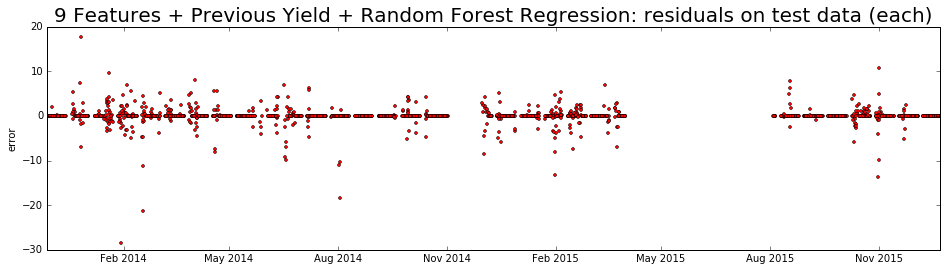

In [371]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_regression - y_test.values.ravel()

for i in xrange(len(err)):
    if abs(err[i]) > 10:
        print(y_test.index[i], 
              'y_regression =', y_regression[i], 
              '; y_test =', y_test.values[i][0])

ax.plot_date(y_test.index, err, c='r', ms=3)
ax.set_title('9 Features + Previous Yield + Random Forest Regression: residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

# cc = 0
# for i in xrange(err.shape[0]):
#     if y_regression[i] - y_test.values[0][i] < 0:
#         cc += 1

<div class="alert alert-danger">
Read training set for 5 minites interval.
</div>

In [459]:
X_5min = microclimate_5min.copy()

X_time = microclimate_train.copy()
y_time = labels.copy()

X_time = X_time.drop(labels=X_time.index[0:4], axis=0).copy()
y_time = y_time.drop(labels=y_time.index[0:4], axis=0).copy()
        
X_time.fillna(method='pad')
        
for timestamp in X_time.index:
    if np.isnan(X_time.loc[timestamp]['percip_mm']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['gusts_ms']):
        X_time = X_time.drop(labels=timestamp, axis=0).copy()
        y_time = y_time.drop(labels=timestamp, axis=0).copy()
    elif np.isnan(X_time.loc[timestamp]['leafwet460_min']):
        X_time.loc[timestamp]['leafwet460_min'] = 0      

In [461]:
X_joint = X_time.copy()
y_new = y_time.copy()

for i in [60]:
    X_joint['pre_' + str(i) + '_min_leafwet450_min'] = np.nan

for timestamp in X_joint.index:
    # Add pre_x_min_wind_dir features.
    for i in [60]:
        pre_time = timestamp - pd.DateOffset(minutes=i)
        if pre_time in X_5min.index:
            pre_wind_dir = X_5min.loc[pre_time]['leafwet450_min']
            if isinstance(pre_wind_dir, pd.Series):
                pre_wind_dir = pre_wind_dir.mean()
            if timestamp in X_joint.index:
                if not np.isnan(pre_wind_dir):
                    X_joint.loc[timestamp]['pre_' + str(i) + '_min_leafwet450_min'] = pre_wind_dir
                else:
                    X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
                    y_new = y_new.drop(labels=timestamp, axis=0).copy()
        elif timestamp in X_joint.index:
            X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
            y_new = y_new.drop(labels=timestamp, axis=0).copy()

# for i in [60]:
#     X_joint['pre_' + str(i) + '_min_humidity'] = np.nan

# for timestamp in X_joint.index:
#     # Add pre_x_min_wind_dir features.
#     for i in [60]:
#         pre_time = timestamp - pd.DateOffset(minutes=i)
#         if pre_time in X_5min.index:
#             pre_wind_dir = X_5min.loc[pre_time]['humidity']
#             if isinstance(pre_wind_dir, pd.Series):
#                 pre_wind_dir = pre_wind_dir.mean()
#             if timestamp in X_joint.index:
#                 if not np.isnan(pre_wind_dir):
#                     X_joint.loc[timestamp]['pre_' + str(i) + '_min_humidity'] = pre_wind_dir
#                 else:
#                     X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
#                     y_new = y_new.drop(labels=timestamp, axis=0).copy()
#         elif timestamp in X_joint.index:
#             X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
#             y_new = y_new.drop(labels=timestamp, axis=0).copy()
    
for i in [2]:
    offset = i
    y_pretime = y_new.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_new, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)
    
for timestamp in X_joint.index:
    for i in [2]:
        if np.isnan(X_joint.loc[timestamp]['pre_yield_' + str(i) + '_hours']):
            X_joint = X_joint.drop(labels=timestamp, axis=0).copy()
            y_new = y_new.drop(labels=timestamp, axis=0).copy()
            
normalize(X_joint, copy=False)

array([[ 0.        ,  0.00081023,  0.01875063, ...,  0.00675496,
         0.        ,  0.        ],
       [ 0.        ,  0.00083789,  0.01835939, ...,  0.00668447,
         0.        ,  0.        ],
       [ 0.        ,  0.00082839,  0.02010736, ...,  0.00796867,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.00078708,  0.03060067, ...,  0.00572088,
         0.        ,  0.        ],
       [ 0.        ,  0.00081195,  0.02876198, ...,  0.00888447,
         0.        ,  0.        ],
       [ 0.        ,  0.00084619,  0.02856601, ...,  0.00986602,
         0.        ,  0.        ]])

In [462]:
X_train, X_test, y_train, y_test = train_test_split(X_joint,
                                                    y_new,
                                                    test_size=0.3, random_state=100)

In [465]:
estimator = ensemble.RandomForestRegressor()
estimator.fit(X_train, y_train)
y_hat_regression = estimator.predict(X_test)

print(X_joint.dtypes)
print(estimator.feature_importances_)

percip_mm                    float64
humidity                     float64
temp                         float64
leafwet450_min               float64
leafwet460_min               float64
leafwet_lwscnt               float64
gusts_ms                     float64
wind_dir                     float64
wind_ms                      float64
pre_60_min_leafwet450_min    float64
pre_yield_2_hours            float64
dtype: object
[ 0.01091411  0.03005162  0.01676261  0.06731375  0.01565307  0.02175151
  0.01399339  0.02684019  0.01895397  0.11895263  0.65881314]


/Users/Shauro/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


In [466]:
y_for_ada = y_train.copy()

for timestamp in y_for_ada.index:
    if y_for_ada.loc[timestamp]['yield'] > 0:
        y_for_ada.loc[timestamp]['yield'] = 1

estimator = ensemble.AdaBoostClassifier(n_estimators=40,learning_rate=1)
#estimator = svm.SVC(C=1.0, kernel='poly', degree=30, gamma='auto', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=None, random_state=None)
estimator.fit(X_train, y_for_ada)
y_hat = estimator.predict(X_test)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0
for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_hat[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_hat[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

print(1.0*55/373)

# estimator.score(X_test, y_test)
# estimator.staged_score(X_test, y_test)
# rmse = np.sqrt(mean_squared_error(y_test, y_hat))
# rmse

# X_joint = pd.concat([X_train, y_train], axis=1, join='outer')
# X_joint.head(n=1000)

/Users/Shauro/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


test size = 1712
right_predict_count = 1632
in right_predict_count: zero_to_zero = 1292
in right_predict_count: one_to_one = 340
wrong_predict_count = 80
in wrong_predict_count: zero_to_one = 33
0.0249056603774
in wrong_predict_count: one_to_zero = 47
0.121447028424
0.14745308311


In [467]:
y_classifier = np.copy(y_hat)
y_regression = np.copy(y_hat_regression)

predict_total = y_test.copy()

for i in xrange(y_regression.shape[0]):
    if abs(y_regression[i]) < 0.01 :
        y_regression[i] = 0
# print(y_regression)

predict_total['y_classider'] = y_classifier
predict_total['y_regression'] = y_regression

# for i in xrange(y_regression.shape[0]):
#     predict_total.append((y_classifier[i], y_regression[i], y_test.values[i]))
# print(predict_total)

wrong_predict_count = 0
zero_to_one = 0
one_to_zero = 0
one_to_one = 0
zero_to_zero = 0

for i in xrange(y_test.shape[0]):
    if y_test.values[i] == 0:
        if y_regression[i] == 0:
            zero_to_zero += 1
        else:
            wrong_predict_count += 1
            zero_to_one += 1
    else:
        if y_regression[i] == 0:
            wrong_predict_count += 1
            one_to_zero += 1
        else:
            one_to_one += 1
            
print('test size =', y_test.shape[0])
# print('non-zeron in y_hat =', np.count_nonzero(y_hat))
print('right_predict_count =', y_test.shape[0] - wrong_predict_count)
print('in right_predict_count: zero_to_zero =', zero_to_zero)
print('in right_predict_count: one_to_one =', one_to_one)
print('wrong_predict_count =', wrong_predict_count)
print('in wrong_predict_count: zero_to_one =', zero_to_one)
print(1.0*zero_to_one/(zero_to_one+zero_to_zero))
print('in wrong_predict_count: one_to_zero =', one_to_zero)
print(1.0*one_to_zero/(one_to_one+one_to_zero))

rmse = np.sqrt(mean_squared_error(y_test, y_regression))
print('loss =', rmse)
        
predict_total.head(n=1734)

predict_total.to_csv("./three_combine_pre_yield_pre_wind_dir_2.csv")

test size = 1712
right_predict_count = 1566
in right_predict_count: zero_to_zero = 1201
in right_predict_count: one_to_one = 365
wrong_predict_count = 146
in wrong_predict_count: zero_to_one = 124
0.0935849056604
in wrong_predict_count: one_to_zero = 22
0.0568475452196
loss = 1.65848561311


2015-01-31 16:00:00 y_regression = 20.215301002 ; y_test = 30.2745262
2014-04-17 22:00:00 y_regression = 12.0784559647 ; y_test = 23.97575251
2015-01-16 18:00:00 y_regression = 6.0319119284 ; y_test = 16.47157191
2014-03-22 14:00:00 y_regression = 16.5022296554 ; y_test = 0.00696767
2015-10-31 18:00:00 y_regression = 3.7256131553 ; y_test = 16.10925307
2015-01-31 18:00:00 y_regression = 16.9579152723 ; y_test = 29.2990524


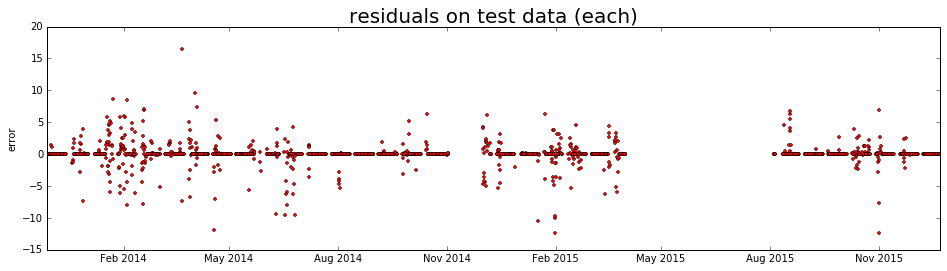

gusts_ms                    NaN
humidity                    NaN
leafwet450_min              NaN
leafwet460_min              NaN
leafwet_lwscnt              NaN
percip_mm                   NaN
pre_60_min_leafwet450_min   NaN
pre_yield_2_hours           NaN
temp                        NaN
wind_dir                    NaN
wind_ms                     NaN
yield                       NaN
dtype: float64


In [468]:
fig, ax = plt.subplots(figsize=(16, 4))
err = y_regression - y_test.values.ravel()

for i in xrange(len(err)):
    if abs(err[i]) > 10:
        print(y_test.index[i], 
              'y_regression =', y_regression[i], 
              '; y_test =', y_test.values[i][0])

ax.plot_date(y_test.index, err, c='r', ms=3)
ax.set_title('residuals on test data (each)', fontsize=20)
ax.set_ylabel('error')

plt.show()

corr0 = X_joint.corrwith(y_new)
print(corr0)

# cc = 0
# for i in xrange(err.shape[0]):
#     if y_regression[i] - y_test.values[0][i] < 0:
#         cc += 1

In [ ]:
for i in [2,4,6,8,18,20,22]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)

In [ ]:
X_time = microclimate_train.copy()
y_time = labels.copy()
X_joint = microclimate_train.copy()

for i in [2,4,6,8,18,20,22]:
    offset = i
    y_pretime = labels.copy()
    y_pretime.index = y_pretime.index + pd.DateOffset(hours=offset)
    y_pretime = y_pretime.rename(columns={'yield': 'pre_yield_' + str(offset) + '_hours'})
    y_joint = pd.concat([y_time, y_pretime], axis=1, join='inner')
    X_joint = pd.concat([X_joint, y_joint], axis=1, join='outer')
    X_joint = X_joint.drop(labels='yield', axis=1)